# Customer Segmentation to Identify Potential Profiles

# Libraries

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import silhouette_score

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)

from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture

pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

from utils.customers_data_prep   import CustomersDataPrep
from utils.customers_feature_eng import CustomersFeatureEng
from utils.utils import cluster_metrics

from yellowbrick.features import PCA
from yellowbrick.cluster import SilhouetteVisualizer

import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("customer_churn.csv")

data_preparer = CustomersDataPrep()
feature_engine = CustomersFeatureEng()

# Data Prep

In [3]:
df = data_preparer.prepare_data(df=df, conditionals=True)
df = feature_engine.create_features(df)

# Feature Engineering

In [4]:
X = df.drop(["Churn"], axis=1).copy()
y = df["Churn"].copy()

In [5]:
features = ["MonthlyCharges", "tenure", "InternetServices"]

X = X[features]
X = StandardScaler().fit_transform(X)

# Model Selection

In [6]:
models = {
    "K-Means": KMeans(n_clusters=5, random_state=42),
    "DBSCAN": DBSCAN(eps=0.1, min_samples=12, leaf_size=40),
    "GaussianMixture": GaussianMixture(n_components=5, random_state=42)
}


K-Means Results


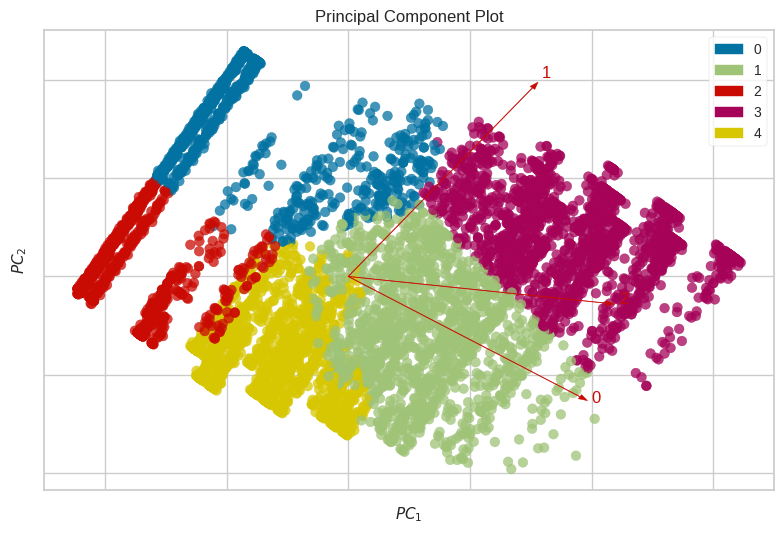

Results for K-Means:
Silhouette Score: 0.3642898693821019
Davies-Bouldin Score: 0.9825587059901189
Calinski-Harabasz Score: 6239.900252618917
Adjusted Mutual Information: 0.0705550529865399
Homogeneity: 0.13281739607982468
Completeness: 0.04826229592094083
V-Measure: 0.07079835847110019
Fowlkes-Mallows Score: 0.38140115926894896


DBSCAN Results


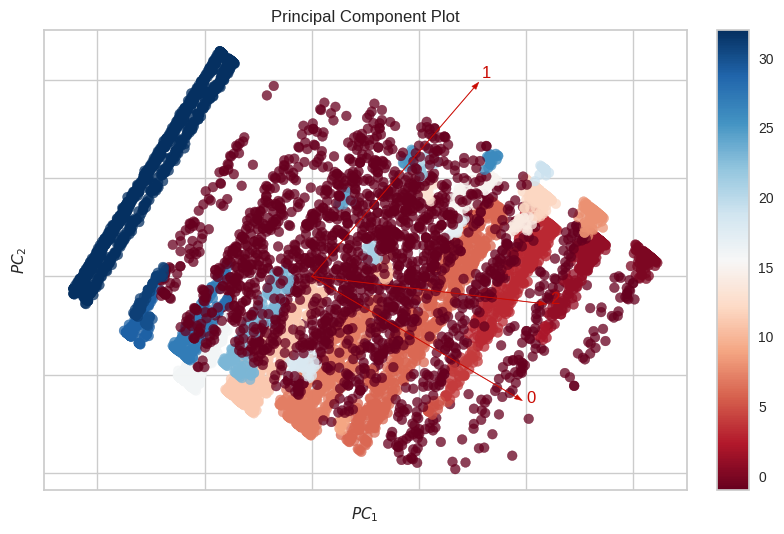

Results for DBSCAN:
Silhouette Score: -0.043224709281079306
Davies-Bouldin Score: 1.4041684564411203
Calinski-Harabasz Score: 583.3610655159703
Adjusted Mutual Information: 0.06276981175889265
Homogeneity: 0.16630061559279374
Completeness: 0.03984857230623728
V-Measure: 0.06429171196412324
Fowlkes-Mallows Score: 0.3551280834191337


GaussianMixture Results


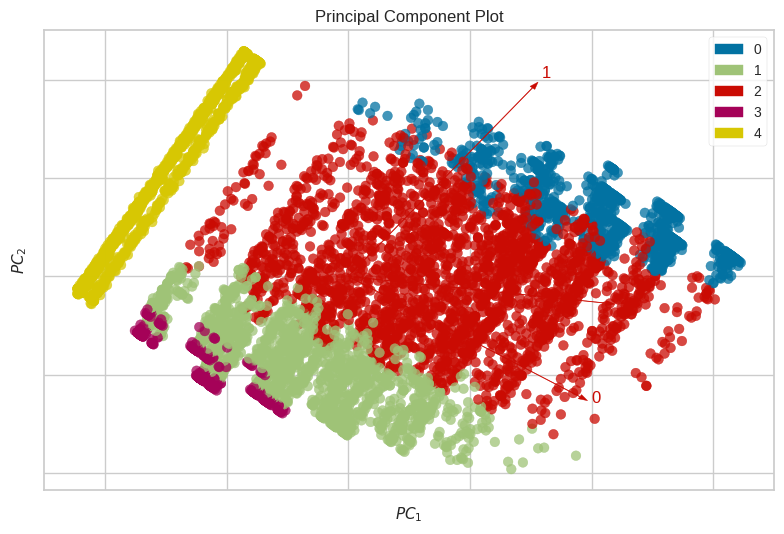

Results for GaussianMixture:
Silhouette Score: 0.170622668955127
Davies-Bouldin Score: 1.369064468113742
Calinski-Harabasz Score: 3426.8882666305935
Adjusted Mutual Information: 0.08502298187087161
Homogeneity: 0.1531070334023659
Completeness: 0.05909248115445433
V-Measure: 0.08527328165513867
Fowlkes-Mallows Score: 0.4239916222895539



In [7]:
for model in models:
    print()
    print(model, "Results")
    models[model].fit(X)
    if model != "DBSCAN":
        labels_pred = models[model].predict(X)
        visualizer = PCA(scale=True, proj_features=True)
        visualizer.fit_transform(X, labels_pred)
        visualizer.poof()
    else:
        labels_pred = models[model].labels_
        visualizer = PCA(scale=True, proj_features=True)
        visualizer.fit_transform(X, labels_pred)
        visualizer.poof()
    cluster_metrics(model, X, y, labels_pred)


K-Means Results


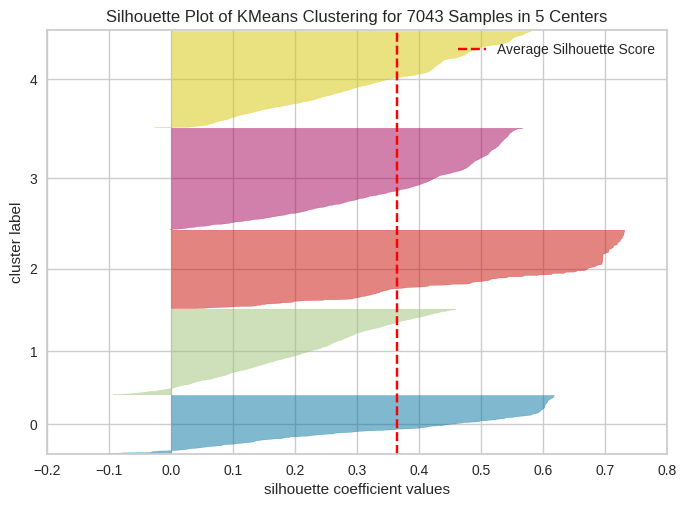

In [8]:
for model in ["K-Means"]:
    print()
    print(model, "Results")
    visualizer = SilhouetteVisualizer(models[model], colors='yellowbrick')
    visualizer.fit(X)
    visualizer.poof()

In [9]:
df["labels_kmeans"] = models["K-Means"].predict(X)
df["labels_dbscan"] = models["DBSCAN"].labels_
df["labels_gmm"] = models["GaussianMixture"].predict(X)

In [10]:
labels_df = ["labels_kmeans", "labels_dbscan", "labels_gmm"]

for label in ["labels_kmeans", "labels_gmm"]:
    data = df[[*features, label]]
    fig = go.Figure()
    size_to_class = {0:'yellow',
                      1:'grey',
                      2:'green',
                      3:'blue',
                      4:'red'}
    for size_class in data[label].unique():
        class_df = data[data[label] == size_class]
        fig.add_trace(go.Scatter3d(
            x=class_df.iloc[:, 0],
            y=class_df.iloc[:, 1],
            z=class_df.iloc[:, 2],
            mode='markers',
            name=f'Grupo {size_class}',
            marker=dict(size=5, color=size_to_class[size_class])
        ))

    fig.update_layout(scene=dict(xaxis_title=class_df.iloc[:, 0].name,
                                  yaxis_title=class_df.iloc[:, 1].name,
                                  zaxis_title=class_df.iloc[:, 2].name),
                      margin=dict(l=0, r=0, b=0, t=0),
                      width=600,
                      height=300)
    fig.show()

# Model Results Evaluation

In [11]:
df.groupby("labels_kmeans")[["Churn"]].count()

,Churn
labels_kmeans,
0,976
1,1438
2,1314
3,1699
4,1616


In [12]:
df.groupby("labels_kmeans")[[*features, "Churn"]].mean().style.background_gradient(axis=0)

,MonthlyCharges,tenure,InternetServices,Churn
labels_kmeans,,,,
0,31.462449,54.773566,0.557377,0.039959
1,84.380494,27.079277,3.068150,0.345619
2,26.304148,10.493912,0.176560,0.219939
3,91.547969,61.977045,4.327840,0.122425
4,70.523793,10.212252,1.121287,0.517327


# Results without Churn (just the customers who stand)

In [13]:
df = pd.read_csv("customer_churn.csv")
df = df[df.Churn == "No"]

data_preparer = CustomersDataPrep()
feature_engine = CustomersFeatureEng()

df = data_preparer.prepare_data(df=df, conditionals=True)
df = feature_engine.create_features(df)

X = df.drop(["Churn"], axis=1).copy()
y = df["Churn"].copy()

features = ["MonthlyCharges", "tenure", "InternetServices"]

X = X[features]
X = StandardScaler().fit_transform(X)

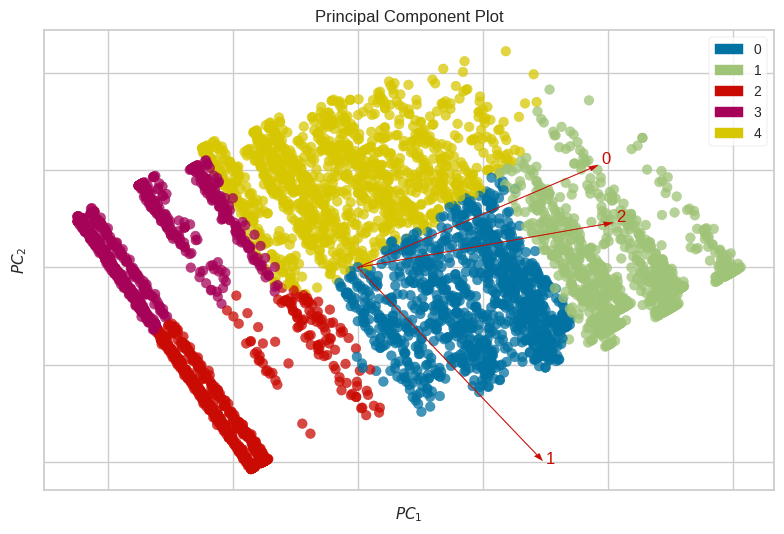

Results for KMeans(n_clusters=5, random_state=42):
Silhouette Score: 0.3792762956075353
Davies-Bouldin Score: 0.9696981766042088
Calinski-Harabasz Score: 5134.392956183885
Adjusted Mutual Information: 0.0
Homogeneity: 1.0
Completeness: 0.0
V-Measure: 0.0
Fowlkes-Mallows Score: 0.4523761342850946



In [14]:
model = KMeans(n_clusters=5, random_state=42)

labels_pred = model.fit_predict(X)
visualizer = PCA(scale=True, proj_features=True)
visualizer.fit_transform(X, labels_pred)
visualizer.poof()

cluster_metrics(model, X, y, labels_pred)

In [15]:
df["labels_kmeans"] = model.predict(X)

for label in ["labels_kmeans"]:
    data = df[[*features, label]]
    fig = go.Figure()
    size_to_class = {0:'yellow',
                      1:'grey',
                      2:'green',
                      3:'blue',
                      4:'red'}
    for size_class in data[label].unique():
        class_df = data[data[label] == size_class]
        fig.add_trace(go.Scatter3d(
            x=class_df.iloc[:, 0],
            y=class_df.iloc[:, 1],
            z=class_df.iloc[:, 2],
            mode='markers',
            name=f'Grupo {size_class}',
            marker=dict(size=5, color=size_to_class[size_class])
        ))

    fig.update_layout(scene=dict(xaxis_title=class_df.iloc[:, 0].name,
                                  yaxis_title=class_df.iloc[:, 1].name,
                                  zaxis_title=class_df.iloc[:, 2].name),
                      margin=dict(l=0, r=0, b=0, t=0),
                      width=600,
                      height=300)
    fig.show()

In [16]:
df.groupby("labels_kmeans")[["Churn"]].count()

,Churn
labels_kmeans,
0,1059
1,954
2,783
3,1117
4,1261


In [17]:
df.groupby("labels_kmeans")[features].mean().style.background_gradient(axis=0)

,MonthlyCharges,tenure,InternetServices
labels_kmeans,,,
0,74.229415,55.221907,3.097262
1,99.108962,61.475891,4.975891
2,25.711941,54.385696,0.168582
3,27.233303,11.529096,0.228290
4,73.968914,17.285488,2.088818


# Conclusions

There are groups ranging from “low profile” (cluster 3) to “high profile” (cluster 1). Looking at the images, each one has a peculiarity and we can use some strategies to make low profile customers become high profile.